In [1]:
import numpy as np
import os
import re
import pandas as pd
import matplotlib.pyplot as plt

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.preprocessing import sequence

%matplotlib inline

C:\Program Files\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import tensorflow as tf
os.environ["CUDA_VISIBLE_DEVICES"] = '0' #use GPU with ID=0
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5 # maximun alloc gpu50% of MEM
config.gpu_options.allow_growth = True #allocate dynamically
sess = tf.Session(config = config)

In [4]:
from preprocess import load_from_directory, divide_to_train_and_test, one_hot
from confusion_matrix import print_confusion_matrix

In [5]:
%%time
file_texts, targets = load_from_directory("D:/svruchtel/DATA/USA_Small", 
                                         ["Airfare", "CarRental", "GeneralRetail", "Hotel", "Other", "Parking", "Restaurant",
                                         "Taxi", "Transport"],
                                         max_files_in_one_category=200)

PROBLEM WITH FILE D:/svruchtel/DATA/USA_Small\Airfare\0000079.txt
PROBLEM WITH FILE D:/svruchtel/DATA/USA_Small\Airfare\0000116.txt
PROBLEM WITH FILE D:/svruchtel/DATA/USA_Small\Airfare\0000142.txt
PROBLEM WITH FILE D:/svruchtel/DATA/USA_Small\Airfare\0000182.txt
PROBLEM WITH FILE D:/svruchtel/DATA/USA_Small\GeneralRetail\0000147.txt
PROBLEM WITH FILE D:/svruchtel/DATA/USA_Small\GeneralRetail\0000150.txt
PROBLEM WITH FILE D:/svruchtel/DATA/USA_Small\Hotel\0000081.txt
PROBLEM WITH FILE D:/svruchtel/DATA/USA_Small\Hotel\0000093.txt
PROBLEM WITH FILE D:/svruchtel/DATA/USA_Small\Hotel\0000094.txt
PROBLEM WITH FILE D:/svruchtel/DATA/USA_Small\Hotel\0000095.txt
PROBLEM WITH FILE D:/svruchtel/DATA/USA_Small\Hotel\0000118.txt
PROBLEM WITH FILE D:/svruchtel/DATA/USA_Small\Hotel\0000119.txt
PROBLEM WITH FILE D:/svruchtel/DATA/USA_Small\Hotel\0000120.txt
PROBLEM WITH FILE D:/svruchtel/DATA/USA_Small\Hotel\0000121.txt
PROBLEM WITH FILE D:/svruchtel/DATA/USA_Small\Hotel\0000122.txt
PROBLEM WITH FIL

In [7]:
text_1 = file_texts[0]
print(text_1)

      Receipt for Beirut  Aug 10, 2017 - Aug 28, 2017                  Itinerary # 7285684220348                 Booked Items    â€¢  Flight: Cincinnati (CVG) to Beirut (BEY)    Depart: 8/10/2017 | Return: 8/28/2017 ,1 round trip ticket    Traveler Information    â€¢  BAHIGE ELRAYES - Adult    Ticket # 0578643753685    Cost Summary   Booked Date: Aug 4, 2017    Traveler 1:  Adult      $2,374.96    Flight      $1,750.00    Taxes &  Fees       $624.96        $10.00    Expedia  Booking  Fee         Total: $2,384.96           Paid: $2,384.96   [AmericanExpress 2002]  All prices quoted in US  dollars.            


In [14]:
#print(list(text_1))

text_new = [char for char in list(text_1) if char != ' ']
print(text_new)


['R', 'e', 'c', 'e', 'i', 'p', 't', 'f', 'o', 'r', 'B', 'e', 'i', 'r', 'u', 't', 'A', 'u', 'g', '1', '0', ',', '2', '0', '1', '7', '-', 'A', 'u', 'g', '2', '8', ',', '2', '0', '1', '7', 'I', 't', 'i', 'n', 'e', 'r', 'a', 'r', 'y', '#', '7', '2', '8', '5', '6', '8', '4', '2', '2', '0', '3', '4', '8', 'B', 'o', 'o', 'k', 'e', 'd', 'I', 't', 'e', 'm', 's', 'â', '€', '¢', 'F', 'l', 'i', 'g', 'h', 't', ':', 'C', 'i', 'n', 'c', 'i', 'n', 'n', 'a', 't', 'i', '(', 'C', 'V', 'G', ')', 't', 'o', 'B', 'e', 'i', 'r', 'u', 't', '(', 'B', 'E', 'Y', ')', 'D', 'e', 'p', 'a', 'r', 't', ':', '8', '/', '1', '0', '/', '2', '0', '1', '7', '|', 'R', 'e', 't', 'u', 'r', 'n', ':', '8', '/', '2', '8', '/', '2', '0', '1', '7', ',', '1', 'r', 'o', 'u', 'n', 'd', 't', 'r', 'i', 'p', 't', 'i', 'c', 'k', 'e', 't', 'T', 'r', 'a', 'v', 'e', 'l', 'e', 'r', 'I', 'n', 'f', 'o', 'r', 'm', 'a', 't', 'i', 'o', 'n', 'â', '€', '¢', 'B', 'A', 'H', 'I', 'G', 'E', 'E', 'L', 'R', 'A', 'Y', 'E', 'S', '-', 'A', 'd', 'u', 'l', 't',

In [15]:
#let's try to write another version of "load_embeddins"

def load_embeddings(emb_path, max_embeddings_count=100000):
    emb_word_id_to_vector = {}
    word_to_id = {}
    current_word_id = 0
    with open(emb_path, 'r', encoding='utf-8') as f:
        for line in f:
            if current_word_id <= max_embeddings_count:
                line_split = line.strip().split(" ")
                word = line_split[0]
                word_emb = np.array(line_split[1:], dtype=float)
            
                if word_emb.shape != (300,):
                    print("ERROR! Shape is", word_emb.shape, word)
                    continue
            
                word_to_id[word] = current_word_id
                emb_word_id_to_vector[current_word_id] = word_emb
                current_word_id += 1
            else:
                break
            
    return emb_word_id_to_vector, word_to_id

In [20]:
%%time
emb_char_id_to_vector, char_to_id = load_embeddings("D:/svruchtel/EMBEDDINGS/glove.840B.300d/glove.840B.300d-char.txt", 
                                    max_embeddings_count=300000)

Wall time: 34.1 ms


In [19]:
#word_to_id

In [34]:
def change_texts_to_lists_of_character_embeddings(X, emb_char_id_to_vector, char_to_id, characters_count=3000):
    """
    X - list of strings (original texts)
    """
    
    X_emb = []
    for text in X:
        text_chars = [char for char in list(text) if char != ' ']
        
        embedded_text = []
        current_chars_count = 0
        
        for char in text_chars:
            if char in char_to_id and current_chars_count < characters_count:
                embedded_text.append(emb_char_id_to_vector[char_to_id[char]])
                current_chars_count += 1
        
        # if text is less long than need to be
        while current_chars_count < characters_count:
            embedded_text.append(emb_char_id_to_vector[char_to_id['0']])
            current_chars_count += 1    
        
        X_emb.append(np.array(embedded_text))
    return np.array(X_emb)

In [31]:
#text_1_emb = change_texts_to_lists_of_character_embeddings([text_1], emb_char_id_to_vector, char_to_id, characters_count=1000)

In [32]:
#text_1_emb

In [35]:
%%time
X_emb = change_texts_to_lists_of_character_embeddings(file_texts, emb_char_id_to_vector, char_to_id, characters_count=1000)

Wall time: 8.05 s


In [40]:
X_emb_train, targets_train, X_emb_test, targets_test = divide_to_train_and_test(X_emb, targets, num_categories=9)

In [41]:
y_train = one_hot(targets_train, classes_count=9)
y_test = one_hot(targets_test, classes_count=9)

In [44]:
print(X_emb_train.shape)
print(X_emb_test.shape)
print(y_train.shape)
print(y_test.shape)

(877, 1000, 300)
(102, 1000, 300)
(877, 9)
(102, 9)


In [48]:
#shuffle train
def shuffle_Xy(X, y):
    perm = np.random.permutation(len(X))
    return np.array(X)[perm], np.array(y)[perm]

X_emb_train_shuffled, y_train_shuffled = shuffle_Xy(X_emb_train, y_train)

In [49]:
%%time
# create the model
categories_count = 9

model = Sequential()
model.add(LSTM(100, input_shape=X_emb_train_shuffled[0].shape))
model.add(Dense(9, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
callback = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')
history = model.fit(X_emb_train_shuffled, y_train_shuffled, validation_data=(X_emb_test, y_test),
                    epochs=200, batch_size=20, callbacks=[callback])

# Final evaluation of the model
test_scores = model.evaluate(X_emb_test, y_test, verbose=0)
print("Accuracy: %.2f" % (test_scores[1]))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_2 (Dense)              (None, 9)                 909       
Total params: 161,309
Trainable params: 161,309
Non-trainable params: 0
_________________________________________________________________
None
Train on 877 samples, validate on 102 samples
Epoch 1/200
877/877 [==============================] - 249s 284ms/step - loss: 1.9376 - acc: 0.2702 - val_loss: 1.9978 - val_acc: 0.2353
Epoch 2/200
877/877 [==============================] - 255s 290ms/step - loss: 1.8275 - acc: 0.2748 - val_loss: 2.0159 - val_acc: 0.3039
Epoch 3/200
877/877 [==============================] - 243s 277ms/step - loss: 1.8043 - acc: 0.3238 - val_loss: 1.8520 - val_acc: 0.4216
Epoch 4/200
877/877 [==============================] - 233s 265ms/step

In [50]:
info_df = pd.read_csv('./PARAMETERS_AND_RESULTS/LSTMs.csv', sep='\t', index_col=0)

In [52]:
best_train_acc = max(history.history['acc'])
last_train_acc = history.history['acc'][len(history.history['acc']) - 1]
idx_best_train_acc = np.argmax(np.array(history.history['acc']))

best_train_loss = min(history.history['loss'])
last_train_loss = history.history['loss'][len(history.history['loss']) - 1]
idx_best_train_loss = np.argmin(np.array(history.history['loss']))

best_val_acc = max(history.history['val_acc'])
last_val_acc = history.history['val_acc'][len(history.history['val_acc']) - 1]
idx_best_val_acc = np.argmax(np.array(history.history['val_acc']))

best_val_loss = min(history.history['val_loss'])
last_val_loss = history.history['val_loss'][len(history.history['val_loss']) - 1]
idx_best_val_loss = np.argmin(np.array(history.history['val_loss']))

epochs_count = len(history.history['acc'])

info = {'architecture_str':'LSTM(100) Dense(9, activation="softmax")',
       'dataset_name':'USA_Small', 'embeddings_type':'char', 'embeddings_name':'glove.840B.300d-char',
       'train_size':X_emb_train_shuffled.shape[0], 'test_size':X_emb_test.shape[0], 'batch_size':20,
       'best_train_acc':best_train_acc, 'last_train_acc':last_train_acc, 'idx_best_train_acc':idx_best_train_acc,
       'best_train_loss':best_train_loss, 'last_train_loss': last_train_loss, 'idx_best_train_loss':idx_best_train_loss,
       'best_val_acc':best_val_acc, 'last_val_acc':last_val_acc, 'idx_best_val_acc':idx_best_val_acc,
       'best_val_loss':best_val_loss, 'last_val_loss':last_val_loss, 'idx_best_val_loss':idx_best_val_loss,
       'epochs_count':epochs_count, 'result_acc':test_scores[1]}

info_df = info_df.append(info, ignore_index=True)

info_df.to_csv('./PARAMETERS_AND_RESULTS/LSTMs.csv', sep='\t')

TRAIN CONFUSION MATRIX
Confusion matrix, without normalization
[[130   0   0  21  29   0   0   0   0]
 [ 43   0   0   3  11   0   0   0   0]
 [ 12   0   0   7  26   0   0   0   0]
 [ 27   0   0  50 103   0   0   0   0]
 [ 16   0   0  24 140   0   0   0   0]
 [  0   0   0   1   2   0   0   0   0]
 [  9   0   0  17  29   0   0   0   0]
 [  8   0   0  32  89   0   0   0   0]
 [ 16   0   0  22  10   0   0   0   0]]
Normalized confusion matrix
[[0.72222222 0.         0.         0.11666667 0.16111111 0.
  0.         0.         0.        ]
 [0.75438596 0.         0.         0.05263158 0.19298246 0.
  0.         0.         0.        ]
 [0.26666667 0.         0.         0.15555556 0.57777778 0.
  0.         0.         0.        ]
 [0.15       0.         0.         0.27777778 0.57222222 0.
  0.         0.         0.        ]
 [0.08888889 0.         0.         0.13333333 0.77777778 0.
  0.         0.         0.        ]
 [0.         0.         0.         0.33333333 0.66666667 0.
  0.         0.  

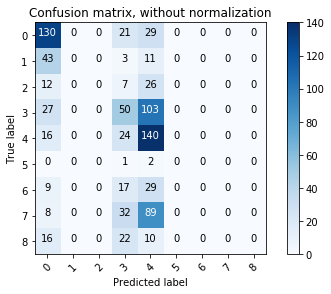

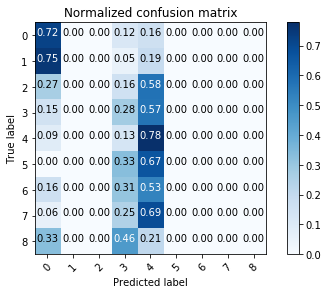

TEST CONFUSION MATRIX
Confusion matrix, without normalization
[[17  0  0  2  1  0  0  0  0]
 [ 1  0  0  0  6  0  0  0  0]
 [ 2  0  0  0  4  0  0  0  0]
 [ 4  0  0  9  7  0  0  0  0]
 [ 1  0  0  4 15  0  0  0  0]
 [ 0  0  0  0  1  0  0  0  0]
 [ 1  0  0  3  3  0  0  0  0]
 [ 2  0  0  3 10  0  0  0  0]
 [ 2  0  0  0  4  0  0  0  0]]
Normalized confusion matrix
[[0.85       0.         0.         0.1        0.05       0.
  0.         0.         0.        ]
 [0.14285714 0.         0.         0.         0.85714286 0.
  0.         0.         0.        ]
 [0.33333333 0.         0.         0.         0.66666667 0.
  0.         0.         0.        ]
 [0.2        0.         0.         0.45       0.35       0.
  0.         0.         0.        ]
 [0.05       0.         0.         0.2        0.75       0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         1.         0.
  0.         0.         0.        ]
 [0.14285714 0.         0.         0.42857143 0.42857143 0.
  0

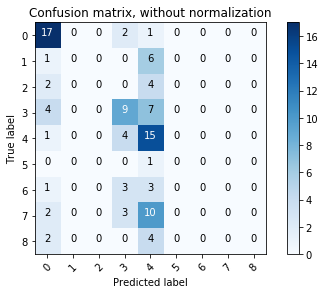

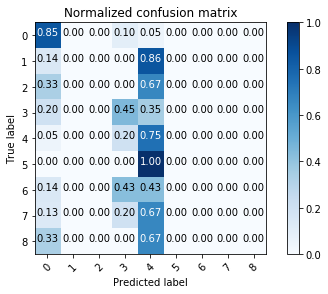

In [53]:
# draw confusion matrix
print("TRAIN CONFUSION MATRIX")
y_pred_train = model.predict(X_emb_train_shuffled)
print_confusion_matrix(X_emb_train_shuffled, y_train_shuffled.argmax(axis=1), y_pred_train.argmax(axis=1), categories_count=9)
print("TEST CONFUSION MATRIX")
y_pred_test = model.predict(X_emb_test)
print_confusion_matrix(X_emb_test, y_test.argmax(axis=1), y_pred_test.argmax(axis=1), categories_count=9)


In [54]:
%%time
# Lets try one another architecture

# create the model
categories_count = 9

model = Sequential()
model.add(LSTM(100, input_shape=X_emb_train_shuffled[0].shape))
model.add(Dropout(0.2))
model.add(Dense(categories_count, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
callback = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')
history = model.fit(X_emb_train_shuffled, y_train_shuffled, validation_data=(X_emb_test, y_test),
                    epochs=200, batch_size=20, callbacks=[callback])

# Final evaluation of the model
test_scores = model.evaluate(X_emb_test, y_test, verbose=0)
print("Accuracy: %.2f" % (test_scores[1]))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 9)                 909       
Total params: 161,309
Trainable params: 161,309
Non-trainable params: 0
_________________________________________________________________
None
Train on 877 samples, validate on 102 samples
Epoch 1/200
877/877 [==============================] - 241s 274ms/step - loss: 1.9311 - acc: 0.2794 - val_loss: 1.9538 - val_acc: 0.2647
Epoch 2/200
877/877 [==============================] - 240s 274ms/step - loss: 1.8563 - acc: 0.2771 - val_loss: 1.9340 - val_acc: 0.3137
Epoch 3/200
877/877 [==============================] - 241s 275ms/step - lo

In [57]:
best_train_acc = max(history.history['acc'])
last_train_acc = history.history['acc'][len(history.history['acc']) - 1]
idx_best_train_acc = np.argmax(np.array(history.history['acc']))

best_train_loss = min(history.history['loss'])
last_train_loss = history.history['loss'][len(history.history['loss']) - 1]
idx_best_train_loss = np.argmin(np.array(history.history['loss']))

best_val_acc = max(history.history['val_acc'])
last_val_acc = history.history['val_acc'][len(history.history['val_acc']) - 1]
idx_best_val_acc = np.argmax(np.array(history.history['val_acc']))

best_val_loss = min(history.history['val_loss'])
last_val_loss = history.history['val_loss'][len(history.history['val_loss']) - 1]
idx_best_val_loss = np.argmin(np.array(history.history['val_loss']))

epochs_count = len(history.history['acc'])

info = {'architecture_str':'LSTM(100) Dropout(0.2) Dense(9, activation="softmax")',
       'dataset_name':'USA_Small', 'embeddings_type':'char', 'embeddings_name':'glove.840B.300d-char',
       'train_size':X_emb_train_shuffled.shape[0], 'test_size':X_emb_test.shape[0], 'batch_size':20,
       'best_train_acc':best_train_acc, 'last_train_acc':last_train_acc, 'idx_best_train_acc':idx_best_train_acc,
       'best_train_loss':best_train_loss, 'last_train_loss': last_train_loss, 'idx_best_train_loss':idx_best_train_loss,
       'best_val_acc':best_val_acc, 'last_val_acc':last_val_acc, 'idx_best_val_acc':idx_best_val_acc,
       'best_val_loss':best_val_loss, 'last_val_loss':last_val_loss, 'idx_best_val_loss':idx_best_val_loss,
       'epochs_count':epochs_count, 'result_acc':test_scores[1]}

info_df = info_df.append(info, ignore_index=True)

info_df.to_csv('./PARAMETERS_AND_RESULTS/LSTMs.csv', sep='\t')

TRAIN CONFUSION MATRIX
Confusion matrix, without normalization
[[130   0   0  23  27   0   0   0   0]
 [ 43   0   0   3  11   0   0   0   0]
 [ 15   0   0   7  23   0   0   0   0]
 [ 20   0   0  57 103   0   0   0   0]
 [ 12   0   0  33 135   0   0   0   0]
 [  0   0   0   1   2   0   0   0   0]
 [  5   0   0  21  29   0   0   0   0]
 [  8   0   0  32  89   0   0   0   0]
 [ 12   0   0  26  10   0   0   0   0]]
Normalized confusion matrix
[[0.72222222 0.         0.         0.12777778 0.15       0.
  0.         0.         0.        ]
 [0.75438596 0.         0.         0.05263158 0.19298246 0.
  0.         0.         0.        ]
 [0.33333333 0.         0.         0.15555556 0.51111111 0.
  0.         0.         0.        ]
 [0.11111111 0.         0.         0.31666667 0.57222222 0.
  0.         0.         0.        ]
 [0.06666667 0.         0.         0.18333333 0.75       0.
  0.         0.         0.        ]
 [0.         0.         0.         0.33333333 0.66666667 0.
  0.         0.  

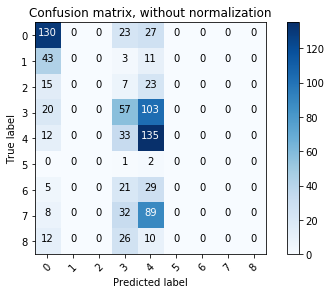

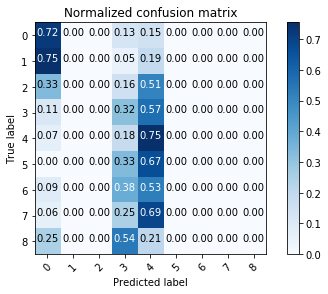

TEST CONFUSION MATRIX
Confusion matrix, without normalization
[[18  0  0  1  1  0  0  0  0]
 [ 1  0  0  0  6  0  0  0  0]
 [ 2  0  0  1  3  0  0  0  0]
 [ 5  0  0  7  8  0  0  0  0]
 [ 0  0  0  5 15  0  0  0  0]
 [ 0  0  0  0  1  0  0  0  0]
 [ 0  0  0  4  3  0  0  0  0]
 [ 1  0  0  4 10  0  0  0  0]
 [ 2  0  0  0  4  0  0  0  0]]
Normalized confusion matrix
[[0.9        0.         0.         0.05       0.05       0.
  0.         0.         0.        ]
 [0.14285714 0.         0.         0.         0.85714286 0.
  0.         0.         0.        ]
 [0.33333333 0.         0.         0.16666667 0.5        0.
  0.         0.         0.        ]
 [0.25       0.         0.         0.35       0.4        0.
  0.         0.         0.        ]
 [0.         0.         0.         0.25       0.75       0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         1.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.57142857 0.42857143 0.
  0

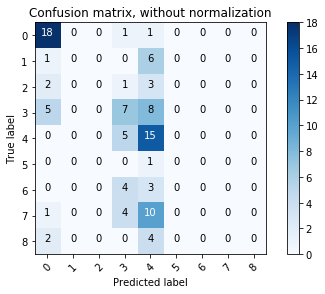

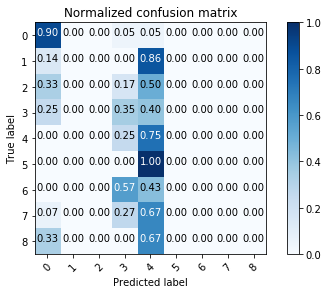

In [58]:
# draw confusion matrix
print("TRAIN CONFUSION MATRIX")
y_pred_train = model.predict(X_emb_train_shuffled)
print_confusion_matrix(X_emb_train_shuffled, y_train_shuffled.argmax(axis=1), y_pred_train.argmax(axis=1), categories_count=9)
print("TEST CONFUSION MATRIX")
y_pred_test = model.predict(X_emb_test)
print_confusion_matrix(X_emb_test, y_test.argmax(axis=1), y_pred_test.argmax(axis=1), categories_count=9)


In [59]:
%%time
# and another

# with recurrent droupout
categories_count = 9

model = Sequential()
model.add(LSTM(100, input_shape=X_emb_train_shuffled[0].shape, recurrent_dropout=0.2))
model.add(Dense(categories_count, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
callback = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')
history = model.fit(X_emb_train_shuffled, y_train_shuffled, validation_data=(X_emb_test, y_test),
                    epochs=200, batch_size=20, callbacks=[callback])

# Final evaluation of the model
test_scores = model.evaluate(X_emb_test, y_test, verbose=0)
print("Accuracy: %.2f" % (test_scores[1]))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_4 (Dense)              (None, 9)                 909       
Total params: 161,309
Trainable params: 161,309
Non-trainable params: 0
_________________________________________________________________
None
Train on 877 samples, validate on 102 samples
Epoch 1/200
877/877 [==============================] - 265s 302ms/step - loss: 1.9250 - acc: 0.2611 - val_loss: 1.9377 - val_acc: 0.2941
Epoch 2/200
877/877 [==============================] - 262s 299ms/step - loss: 1.8459 - acc: 0.3181 - val_loss: 1.9309 - val_acc: 0.3235
Epoch 3/200
877/877 [==============================] - 250s 285ms/step - loss: 1.7887 - acc: 0.3284 - val_loss: 1.9912 - val_acc: 0.3333
Epoch 4/200
877/877 [==============================] - 266s 303ms/step

In [62]:
best_train_acc = max(history.history['acc'])
last_train_acc = history.history['acc'][len(history.history['acc']) - 1]
idx_best_train_acc = np.argmax(np.array(history.history['acc']))

best_train_loss = min(history.history['loss'])
last_train_loss = history.history['loss'][len(history.history['loss']) - 1]
idx_best_train_loss = np.argmin(np.array(history.history['loss']))

best_val_acc = max(history.history['val_acc'])
last_val_acc = history.history['val_acc'][len(history.history['val_acc']) - 1]
idx_best_val_acc = np.argmax(np.array(history.history['val_acc']))

best_val_loss = min(history.history['val_loss'])
last_val_loss = history.history['val_loss'][len(history.history['val_loss']) - 1]
idx_best_val_loss = np.argmin(np.array(history.history['val_loss']))

epochs_count = len(history.history['acc'])

info = {'architecture_str':'LSTM(100, recurrent_dropout=0.2) Dense(9, activation="softmax")',
       'dataset_name':'USA_Small', 'embeddings_type':'char', 'embeddings_name':'glove.840B.300d-char',
       'train_size':X_emb_train_shuffled.shape[0], 'test_size':X_emb_test.shape[0], 'batch_size':20,
       'best_train_acc':best_train_acc, 'last_train_acc':last_train_acc, 'idx_best_train_acc':idx_best_train_acc,
       'best_train_loss':best_train_loss, 'last_train_loss': last_train_loss, 'idx_best_train_loss':idx_best_train_loss,
       'best_val_acc':best_val_acc, 'last_val_acc':last_val_acc, 'idx_best_val_acc':idx_best_val_acc,
       'best_val_loss':best_val_loss, 'last_val_loss':last_val_loss, 'idx_best_val_loss':idx_best_val_loss,
       'epochs_count':epochs_count, 'result_acc':test_scores[1]}

info_df = info_df.append(info, ignore_index=True)

info_df.to_csv('./PARAMETERS_AND_RESULTS/LSTMs.csv', sep='\t')

TRAIN CONFUSION MATRIX
Confusion matrix, without normalization
[[154   0   0   0  26   0   0   0   0]
 [ 47   0   0   0  10   0   0   0   0]
 [ 21   0   0   0  24   0   0   0   0]
 [ 82   0   0   0  98   0   0   0   0]
 [ 55   0   0   1 124   0   0   0   0]
 [  1   0   0   0   2   0   0   0   0]
 [ 27   0   0   0  28   0   0   0   0]
 [ 43   0   0   0  86   0   0   0   0]
 [ 39   0   0   0   9   0   0   0   0]]
Normalized confusion matrix
[[0.85555556 0.         0.         0.         0.14444444 0.
  0.         0.         0.        ]
 [0.8245614  0.         0.         0.         0.1754386  0.
  0.         0.         0.        ]
 [0.46666667 0.         0.         0.         0.53333333 0.
  0.         0.         0.        ]
 [0.45555556 0.         0.         0.         0.54444444 0.
  0.         0.         0.        ]
 [0.30555556 0.         0.         0.00555556 0.68888889 0.
  0.         0.         0.        ]
 [0.33333333 0.         0.         0.         0.66666667 0.
  0.         0.  

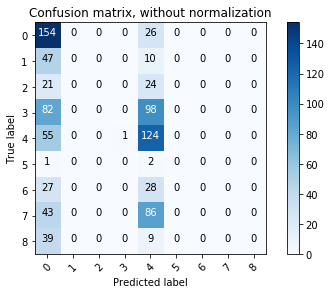

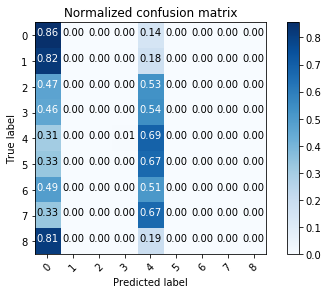

TEST CONFUSION MATRIX
Confusion matrix, without normalization
[[19  0  0  0  1  0  0  0  0]
 [ 1  0  0  0  6  0  0  0  0]
 [ 3  0  0  0  3  0  0  0  0]
 [13  0  0  0  7  0  0  0  0]
 [ 5  0  0  0 15  0  0  0  0]
 [ 0  0  0  0  1  0  0  0  0]
 [ 4  0  0  0  3  0  0  0  0]
 [ 5  0  0  0 10  0  0  0  0]
 [ 2  0  0  0  4  0  0  0  0]]
Normalized confusion matrix
[[0.95       0.         0.         0.         0.05       0.
  0.         0.         0.        ]
 [0.14285714 0.         0.         0.         0.85714286 0.
  0.         0.         0.        ]
 [0.5        0.         0.         0.         0.5        0.
  0.         0.         0.        ]
 [0.65       0.         0.         0.         0.35       0.
  0.         0.         0.        ]
 [0.25       0.         0.         0.         0.75       0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         1.         0.
  0.         0.         0.        ]
 [0.57142857 0.         0.         0.         0.42857143 0.
  0

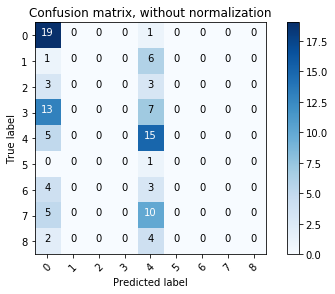

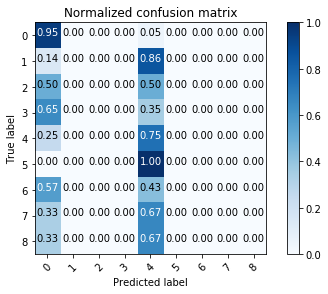

In [63]:
# draw confusion matrix
print("TRAIN CONFUSION MATRIX")
y_pred_train = model.predict(X_emb_train_shuffled)
print_confusion_matrix(X_emb_train_shuffled, y_train_shuffled.argmax(axis=1), y_pred_train.argmax(axis=1), categories_count=9)
print("TEST CONFUSION MATRIX")
y_pred_test = model.predict(X_emb_test)
print_confusion_matrix(X_emb_test, y_test.argmax(axis=1), y_pred_test.argmax(axis=1), categories_count=9)


In [64]:
%%time
# and two LSTM's

# create the model
categories_count = 9

model = Sequential()
model.add(LSTM(100, input_shape=X_emb_train_shuffled[0].shape, recurrent_dropout=0.4, return_sequences=True))
model.add(LSTM(200, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(categories_count, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
callback = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=7, verbose=0, mode='auto')
history = model.fit(X_emb_train_shuffled, y_train_shuffled, validation_data=(X_emb_test, y_test),
                    epochs=200, batch_size=20, callbacks=[callback])

# Final evaluation of the model
test_scores = model.evaluate(X_emb_test, y_test, verbose=0)
print("Accuracy: %.2f" % (test_scores[1]))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 1000, 100)         160400    
_________________________________________________________________
lstm_6 (LSTM)                (None, 200)               240800    
_________________________________________________________________
dense_5 (Dense)              (None, 9)                 1809      
Total params: 403,009
Trainable params: 403,009
Non-trainable params: 0
_________________________________________________________________
None
Train on 877 samples, validate on 102 samples
Epoch 1/200
877/877 [==============================] - 546s 622ms/step - loss: 1.9349 - acc: 0.2452 - val_loss: 2.0090 - val_acc: 0.2843
Epoch 2/200
877/877 [==============================] - 549s 627ms/step - loss: 1.8559 - acc: 0.2908 - val_loss: 1.9164 - val_acc: 0.3725
Epoch 3/200
877/877 [==============================] - 552s 629ms/step - lo

In [65]:
best_train_acc = max(history.history['acc'])
last_train_acc = history.history['acc'][len(history.history['acc']) - 1]
idx_best_train_acc = np.argmax(np.array(history.history['acc']))

best_train_loss = min(history.history['loss'])
last_train_loss = history.history['loss'][len(history.history['loss']) - 1]
idx_best_train_loss = np.argmin(np.array(history.history['loss']))

best_val_acc = max(history.history['val_acc'])
last_val_acc = history.history['val_acc'][len(history.history['val_acc']) - 1]
idx_best_val_acc = np.argmax(np.array(history.history['val_acc']))

best_val_loss = min(history.history['val_loss'])
last_val_loss = history.history['val_loss'][len(history.history['val_loss']) - 1]
idx_best_val_loss = np.argmin(np.array(history.history['val_loss']))

epochs_count = len(history.history['acc'])

info = {'architecture_str':'LSTM(100, recurrent_dropout=0.4, return_sequences=True) LSTM(200, dropout=0.2, recurrent_dropout=0.2) Dense(9, activation="softmax")',
       'dataset_name':'USA_Small', 'embeddings_type':'char', 'embeddings_name':'glove.840B.300d-char',
       'train_size':X_emb_train_shuffled.shape[0], 'test_size':X_emb_test.shape[0], 'batch_size':20,
       'best_train_acc':best_train_acc, 'last_train_acc':last_train_acc, 'idx_best_train_acc':idx_best_train_acc,
       'best_train_loss':best_train_loss, 'last_train_loss': last_train_loss, 'idx_best_train_loss':idx_best_train_loss,
       'best_val_acc':best_val_acc, 'last_val_acc':last_val_acc, 'idx_best_val_acc':idx_best_val_acc,
       'best_val_loss':best_val_loss, 'last_val_loss':last_val_loss, 'idx_best_val_loss':idx_best_val_loss,
       'epochs_count':epochs_count, 'result_acc':test_scores[1]}

info_df = info_df.append(info, ignore_index=True)

info_df.to_csv('./PARAMETERS_AND_RESULTS/LSTMs.csv', sep='\t')

TRAIN CONFUSION MATRIX
Confusion matrix, without normalization
[[ 69   8   0  70  32   0   0   1   0]
 [ 12  30   0   4  11   0   0   0   0]
 [  0   0   6   8  31   0   0   0   0]
 [  2   4   0  68 104   0   0   2   0]
 [  1   2   0  34 143   0   0   0   0]
 [  0   0   0   1   2   0   0   0   0]
 [  0   0   0  25  28   0   0   2   0]
 [  1   0   0  30  98   0   0   0   0]
 [  4   2   0  29  13   0   0   0   0]]
Normalized confusion matrix
[[0.38333333 0.04444444 0.         0.38888889 0.17777778 0.
  0.         0.00555556 0.        ]
 [0.21052632 0.52631579 0.         0.07017544 0.19298246 0.
  0.         0.         0.        ]
 [0.         0.         0.13333333 0.17777778 0.68888889 0.
  0.         0.         0.        ]
 [0.01111111 0.02222222 0.         0.37777778 0.57777778 0.
  0.         0.01111111 0.        ]
 [0.00555556 0.01111111 0.         0.18888889 0.79444444 0.
  0.         0.         0.        ]
 [0.         0.         0.         0.33333333 0.66666667 0.
  0.         0.  

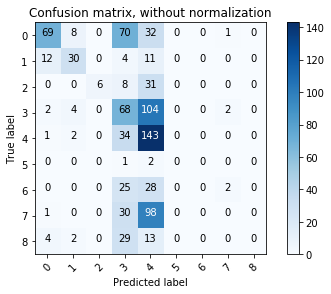

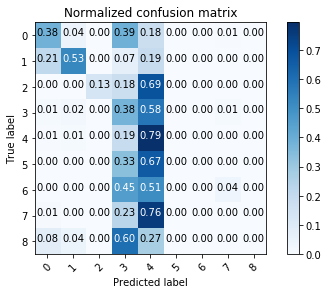

TEST CONFUSION MATRIX
Confusion matrix, without normalization
[[ 6  0  0  9  5  0  0  0  0]
 [ 1  0  0  0  6  0  0  0  0]
 [ 0  0  1  0  5  0  0  0  0]
 [ 0  0  0 12  8  0  0  0  0]
 [ 0  0  0  5 15  0  0  0  0]
 [ 0  0  0  0  1  0  0  0  0]
 [ 0  0  0  3  4  0  0  0  0]
 [ 0  0  0  3 12  0  0  0  0]
 [ 2  0  0  0  4  0  0  0  0]]
Normalized confusion matrix
[[0.3        0.         0.         0.45       0.25       0.
  0.         0.         0.        ]
 [0.14285714 0.         0.         0.         0.85714286 0.
  0.         0.         0.        ]
 [0.         0.         0.16666667 0.         0.83333333 0.
  0.         0.         0.        ]
 [0.         0.         0.         0.6        0.4        0.
  0.         0.         0.        ]
 [0.         0.         0.         0.25       0.75       0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         1.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.42857143 0.57142857 0.
  0

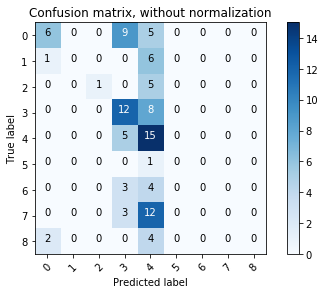

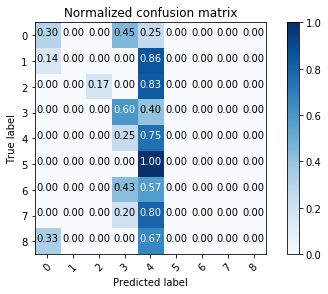

In [66]:
# draw confusion matrix
print("TRAIN CONFUSION MATRIX")
y_pred_train = model.predict(X_emb_train_shuffled)
print_confusion_matrix(X_emb_train_shuffled, y_train_shuffled.argmax(axis=1), y_pred_train.argmax(axis=1), categories_count=9)
print("TEST CONFUSION MATRIX")
y_pred_test = model.predict(X_emb_test)
print_confusion_matrix(X_emb_test, y_test.argmax(axis=1), y_pred_test.argmax(axis=1), categories_count=9)


In [67]:
%%time
# and also with 1d-convolutional layer

# create the model
categories_count = 9

model = Sequential()
model.add(Conv1D(input_shape=X_emb_train_shuffled[0].shape, filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(100))
model.add(Dense(categories_count, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
callback = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')
history = model.fit(X_emb_train_shuffled, y_train_shuffled, validation_data=(X_emb_test, y_test),
                    epochs=200, batch_size=20, callbacks=[callback])

# Final evaluation of the model
test_scores = model.evaluate(X_emb_test, y_test, verbose=0)
print("Accuracy: %.2f" % (test_scores[1]))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 1000, 32)          28832     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 500, 32)           0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_6 (Dense)              (None, 9)                 909       
Total params: 82,941
Trainable params: 82,941
Non-trainable params: 0
_________________________________________________________________
None
Train on 877 samples, validate on 102 samples
Epoch 1/200
877/877 [==============================] - 181s 207ms/step - loss: 1.9348 - acc: 0.2794 - val_loss: 1.9823 - val_acc: 0.2745
Epoch 2/200
877/877 [==============================] - 181s 206ms/step - loss: 1.8

In [68]:
best_train_acc = max(history.history['acc'])
last_train_acc = history.history['acc'][len(history.history['acc']) - 1]
idx_best_train_acc = np.argmax(np.array(history.history['acc']))

best_train_loss = min(history.history['loss'])
last_train_loss = history.history['loss'][len(history.history['loss']) - 1]
idx_best_train_loss = np.argmin(np.array(history.history['loss']))

best_val_acc = max(history.history['val_acc'])
last_val_acc = history.history['val_acc'][len(history.history['val_acc']) - 1]
idx_best_val_acc = np.argmax(np.array(history.history['val_acc']))

best_val_loss = min(history.history['val_loss'])
last_val_loss = history.history['val_loss'][len(history.history['val_loss']) - 1]
idx_best_val_loss = np.argmin(np.array(history.history['val_loss']))

epochs_count = len(history.history['acc'])

info = {'architecture_str':'Conv1D(filters=32, kernel_size=3, padding="same", activation="relu") MaxPooling1D(pool_size=2) LSTM(100) Dense(9, activation="softmax")',
       'dataset_name':'USA_Small', 'embeddings_type':'char', 'embeddings_name':'glove.840B.300d-char',
       'train_size':X_emb_train_shuffled.shape[0], 'test_size':X_emb_test.shape[0], 'batch_size':20,
       'best_train_acc':best_train_acc, 'last_train_acc':last_train_acc, 'idx_best_train_acc':idx_best_train_acc,
       'best_train_loss':best_train_loss, 'last_train_loss': last_train_loss, 'idx_best_train_loss':idx_best_train_loss,
       'best_val_acc':best_val_acc, 'last_val_acc':last_val_acc, 'idx_best_val_acc':idx_best_val_acc,
       'best_val_loss':best_val_loss, 'last_val_loss':last_val_loss, 'idx_best_val_loss':idx_best_val_loss,
       'epochs_count':epochs_count, 'result_acc':test_scores[1]}

info_df = info_df.append(info, ignore_index=True)

info_df.to_csv('./PARAMETERS_AND_RESULTS/LSTMs.csv', sep='\t')

TRAIN CONFUSION MATRIX
Confusion matrix, without normalization
[[139   0   0  15  26   0   0   0   0]
 [ 46   0   0   2   9   0   0   0   0]
 [ 17   0   0   5  23   0   0   0   0]
 [ 39   0   0  48  93   0   0   0   0]
 [ 22   0   0  31 127   0   0   0   0]
 [  0   0   0   1   2   0   0   0   0]
 [ 15   0   0  12  28   0   0   0   0]
 [  2   0   0  41  86   0   0   0   0]
 [ 30   0   0   9   9   0   0   0   0]]
Normalized confusion matrix
[[0.77222222 0.         0.         0.08333333 0.14444444 0.
  0.         0.         0.        ]
 [0.80701754 0.         0.         0.03508772 0.15789474 0.
  0.         0.         0.        ]
 [0.37777778 0.         0.         0.11111111 0.51111111 0.
  0.         0.         0.        ]
 [0.21666667 0.         0.         0.26666667 0.51666667 0.
  0.         0.         0.        ]
 [0.12222222 0.         0.         0.17222222 0.70555556 0.
  0.         0.         0.        ]
 [0.         0.         0.         0.33333333 0.66666667 0.
  0.         0.  

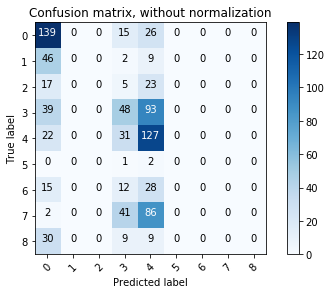

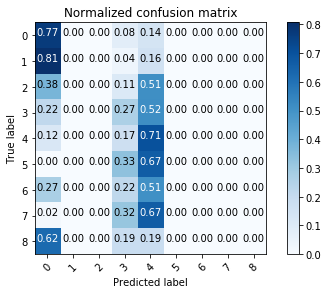

TEST CONFUSION MATRIX
Confusion matrix, without normalization
[[19  0  0  0  1  0  0  0  0]
 [ 1  0  0  0  6  0  0  0  0]
 [ 1  0  0  2  3  0  0  0  0]
 [ 7  0  0  6  7  0  0  0  0]
 [ 1  0  0  4 15  0  0  0  0]
 [ 0  0  0  0  1  0  0  0  0]
 [ 0  0  0  4  3  0  0  0  0]
 [ 0  0  0  5 10  0  0  0  0]
 [ 2  0  0  0  4  0  0  0  0]]
Normalized confusion matrix
[[0.95       0.         0.         0.         0.05       0.
  0.         0.         0.        ]
 [0.14285714 0.         0.         0.         0.85714286 0.
  0.         0.         0.        ]
 [0.16666667 0.         0.         0.33333333 0.5        0.
  0.         0.         0.        ]
 [0.35       0.         0.         0.3        0.35       0.
  0.         0.         0.        ]
 [0.05       0.         0.         0.2        0.75       0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         1.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.57142857 0.42857143 0.
  0

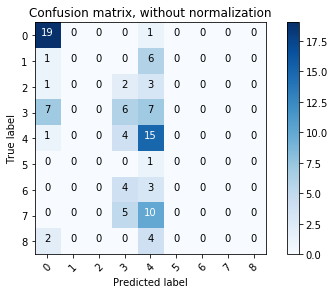

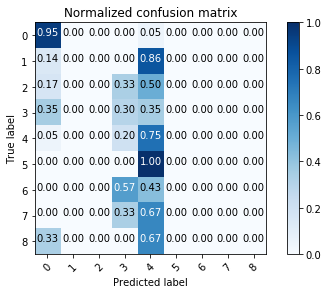

In [69]:
# draw confusion matrix
print("TRAIN CONFUSION MATRIX")
y_pred_train = model.predict(X_emb_train_shuffled)
print_confusion_matrix(X_emb_train_shuffled, y_train_shuffled.argmax(axis=1), y_pred_train.argmax(axis=1), categories_count=9)
print("TEST CONFUSION MATRIX")
y_pred_test = model.predict(X_emb_test)
print_confusion_matrix(X_emb_test, y_test.argmax(axis=1), y_pred_test.argmax(axis=1), categories_count=9)


In [70]:
%%time

# create the model
categories_count = 9

model = Sequential()
model.add(Conv1D(input_shape=X_emb_train_shuffled[0].shape, filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(100, recurrent_dropout=0.2))
model.add(Dense(categories_count, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
callback = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')
history = model.fit(X_emb_train_shuffled, y_train_shuffled, validation_data=(X_emb_test, y_test),
                    epochs=200, batch_size=20, callbacks=[callback])

# Final evaluation of the model
test_scores = model.evaluate(X_emb_test, y_test, verbose=0)
print("Accuracy: %.2f" % (test_scores[1]))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 1000, 32)          28832     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 500, 32)           0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_7 (Dense)              (None, 9)                 909       
Total params: 82,941
Trainable params: 82,941
Non-trainable params: 0
_________________________________________________________________
None
Train on 877 samples, validate on 102 samples
Epoch 1/200
877/877 [==============================] - 192s 219ms/step - loss: 1.9594 - acc: 0.2520 - val_loss: 2.0014 - val_acc: 0.2157
Epoch 2/200
877/877 [==============================] - 188s 215ms/step - loss: 1.8

In [71]:
best_train_acc = max(history.history['acc'])
last_train_acc = history.history['acc'][len(history.history['acc']) - 1]
idx_best_train_acc = np.argmax(np.array(history.history['acc']))

best_train_loss = min(history.history['loss'])
last_train_loss = history.history['loss'][len(history.history['loss']) - 1]
idx_best_train_loss = np.argmin(np.array(history.history['loss']))

best_val_acc = max(history.history['val_acc'])
last_val_acc = history.history['val_acc'][len(history.history['val_acc']) - 1]
idx_best_val_acc = np.argmax(np.array(history.history['val_acc']))

best_val_loss = min(history.history['val_loss'])
last_val_loss = history.history['val_loss'][len(history.history['val_loss']) - 1]
idx_best_val_loss = np.argmin(np.array(history.history['val_loss']))

epochs_count = len(history.history['acc'])

info = {'architecture_str':'Conv1D(filters=32, kernel_size=3, padding="same", activation="relu") MaxPooling1D(pool_size=2) LSTM(100, recurrent_dropout=0.2) Dense(9, activation="softmax")',
       'dataset_name':'USA_Small', 'embeddings_type':'char', 'embeddings_name':'glove.840B.300d-char',
       'train_size':X_emb_train_shuffled.shape[0], 'test_size':X_emb_test.shape[0], 'batch_size':20,
       'best_train_acc':best_train_acc, 'last_train_acc':last_train_acc, 'idx_best_train_acc':idx_best_train_acc,
       'best_train_loss':best_train_loss, 'last_train_loss': last_train_loss, 'idx_best_train_loss':idx_best_train_loss,
       'best_val_acc':best_val_acc, 'last_val_acc':last_val_acc, 'idx_best_val_acc':idx_best_val_acc,
       'best_val_loss':best_val_loss, 'last_val_loss':last_val_loss, 'idx_best_val_loss':idx_best_val_loss,
       'epochs_count':epochs_count, 'result_acc':test_scores[1]}

info_df = info_df.append(info, ignore_index=True)

info_df.to_csv('./PARAMETERS_AND_RESULTS/LSTMs.csv', sep='\t')

TRAIN CONFUSION MATRIX
Confusion matrix, without normalization
[[113  10   0  28  29   0   0   0   0]
 [ 21  22   0   4  10   0   0   0   0]
 [  7   0   0   7  31   0   0   0   0]
 [ 16   0   0  64 100   0   0   0   0]
 [  3   1   0  38 138   0   0   0   0]
 [  0   0   0   1   2   0   0   0   0]
 [  3   0   0  16  35   0   1   0   0]
 [  3   0   0  50  76   0   0   0   0]
 [  9   2   0  26  11   0   0   0   0]]
Normalized confusion matrix
[[0.62777778 0.05555556 0.         0.15555556 0.16111111 0.
  0.         0.         0.        ]
 [0.36842105 0.38596491 0.         0.07017544 0.1754386  0.
  0.         0.         0.        ]
 [0.15555556 0.         0.         0.15555556 0.68888889 0.
  0.         0.         0.        ]
 [0.08888889 0.         0.         0.35555556 0.55555556 0.
  0.         0.         0.        ]
 [0.01666667 0.00555556 0.         0.21111111 0.76666667 0.
  0.         0.         0.        ]
 [0.         0.         0.         0.33333333 0.66666667 0.
  0.         0.  

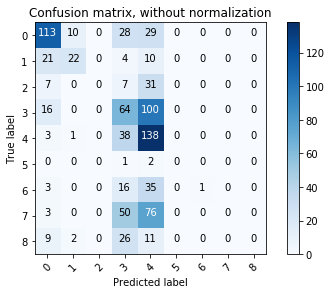

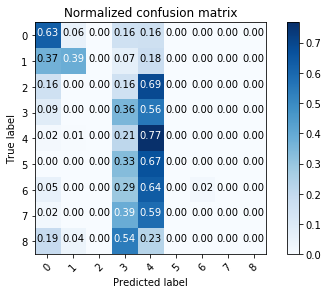

TEST CONFUSION MATRIX
Confusion matrix, without normalization
[[14  2  0  2  2  0  0  0  0]
 [ 1  0  0  0  6  0  0  0  0]
 [ 1  0  0  2  3  0  0  0  0]
 [ 1  0  0 13  6  0  0  0  0]
 [ 0  0  0  5 15  0  0  0  0]
 [ 0  0  0  0  1  0  0  0  0]
 [ 0  0  0  3  4  0  0  0  0]
 [ 1  0  0  4 10  0  0  0  0]
 [ 2  0  0  0  4  0  0  0  0]]
Normalized confusion matrix
[[0.7        0.1        0.         0.1        0.1        0.
  0.         0.         0.        ]
 [0.14285714 0.         0.         0.         0.85714286 0.
  0.         0.         0.        ]
 [0.16666667 0.         0.         0.33333333 0.5        0.
  0.         0.         0.        ]
 [0.05       0.         0.         0.65       0.3        0.
  0.         0.         0.        ]
 [0.         0.         0.         0.25       0.75       0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         1.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.42857143 0.57142857 0.
  0

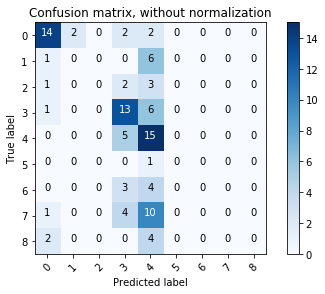

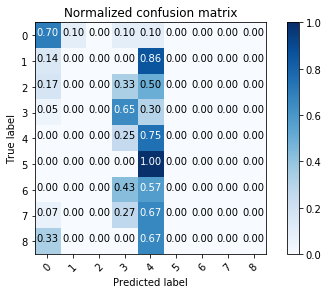

In [73]:
# draw confusion matrix
print("TRAIN CONFUSION MATRIX")
y_pred_train = model.predict(X_emb_train_shuffled)
print_confusion_matrix(X_emb_train_shuffled, y_train_shuffled.argmax(axis=1), y_pred_train.argmax(axis=1), categories_count=9)
print("TEST CONFUSION MATRIX")
y_pred_test = model.predict(X_emb_test)
print_confusion_matrix(X_emb_test, y_test.argmax(axis=1), y_pred_test.argmax(axis=1), categories_count=9)
